# Stage 1

- has **`location_raw`**: False
- vars one-hot encoded: True
- var label-encoded: False
- oversampled: False

In [1]:
import pickle

import humanize
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.externals.joblib import parallel_backend
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split


%matplotlib inline
%load_ext autoreload

In [2]:
X_train = pickle.load(open('./data/stage1-train.pkl', 'rb'))
y_train = X_train.pop('stop_outcome')
X_test = pickle.load(open('./data/stage1-test.pkl', 'rb'))
y_test = X_test.pop('stop_outcome')

print('Row counts:\n\ttrain: {}\n\ttest: {}'.format(X_train.shape[0], X_test.shape[0]))


Row counts:
	train: 250118
	test: 62530


### Correlation matrix plot

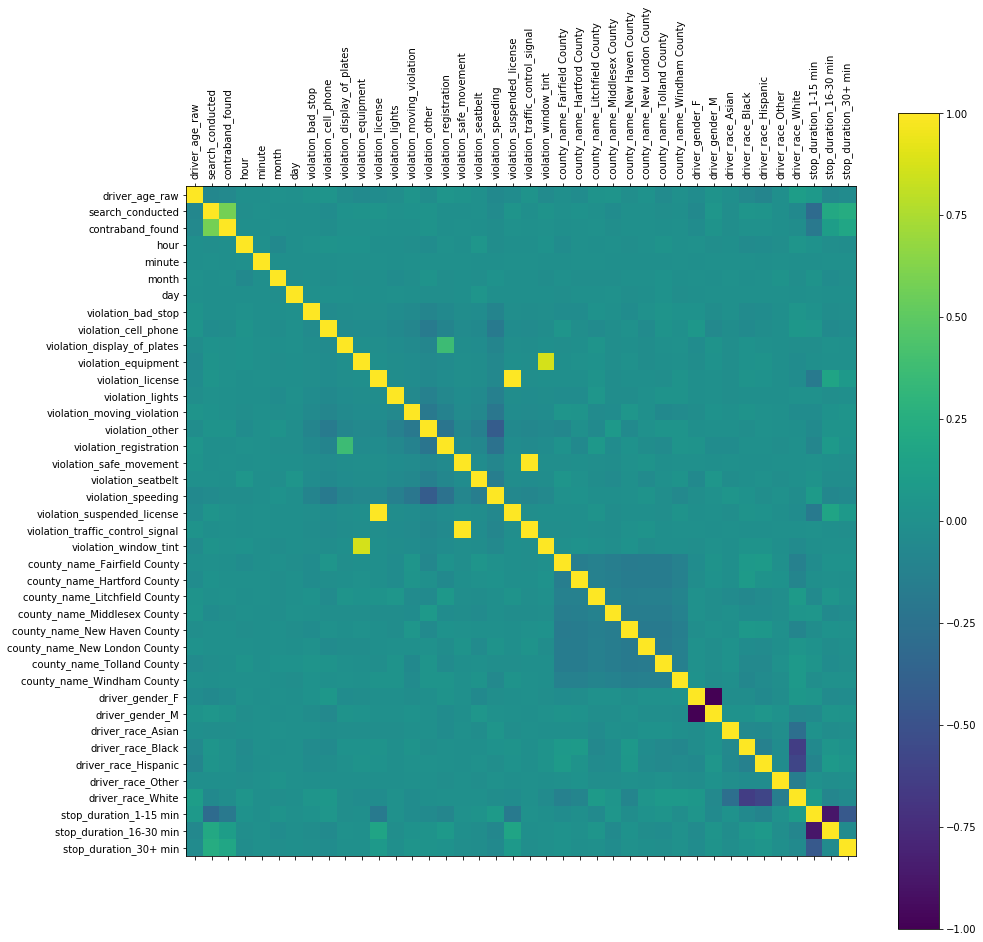

In [13]:
import matplotlib.pyplot as plt
import pandas
import numpy

# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# data = pandas.read_csv(url, names=names)
# correlations = data.corr()
names = X_train.columns.values
correlations = X_train.corr()

# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,names.shape[0],1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)
plt.show()

# Classifiers

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


class Classifier(object):
    def __init__(self, classifier):
        self.clf = classifier
        self.fitted = False
        self.name = self.get_name(self.clf)
        self.score_val = 0.0

    def get_name(self, classifier):
        return str(classifier.__class__).split('.')[-1].replace("'>", "")
        
    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        self.fitted = True

    def score(self, X_train, y_train):
        if self.fitted:
            print('Scoring...')
            self.score_val = self.clf.score(X_train, y_train)
            print(self.score_val)
        else:
            print('Please run the .fit() method first')

        
clf = {
    'sgd': Classifier(SGDClassifier()),
    'gnb': Classifier(GaussianNB()),
    'dtc': Classifier(DecisionTreeClassifier(random_state=0)),
    'rfc': Classifier(RandomForestClassifier(n_jobs=8, verbose=3, random_state=0)),
    'gbc': Classifier(GradientBoostingClassifier(random_state=0)),
    'gbc_tuned': Classifier(GradientBoostingClassifier(
    #     learning_rate=0.0983,
        max_depth=6,
    #     max_features=len(list(X_train.columns.values)),
        subsample=0.9,
        verbose=3,
        random_state=0,
    )),
}
        
    

In [4]:
# Split the 'features' and 'labels' data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features,
#                                                     labels, 
#                                                     test_size=0.2, 
#                                                     random_state=0)
# final_test_features = pickle.load(open('./data/final_test_set.pkl', 'rb'))
# final_test_outcomes = final_test_features.pop('stop_outcome')
# print('Final test set row count: {}'.format(final_test_features.shape[0]))

# X_train = features
# y_train = labels
# X_test = final_test_features
# y_test = final_test_outcomes

# Benchmark

In [5]:
# LabelEncoded value for "Ticket" outcome is 2
predictions = [2]
accuracy_score(y_test, predictions * y_test.shape[0])

0.69125219894450662

# Simple Linear Classifier

In [6]:
clf['sgd'].fit(X_train, y_train)
clf['sgd'].score(X_test, y_test)

/home/pato/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Scoring...
0.694370702063


# GaussianNB

In [7]:
clf['gnb'].fit(X_train, y_train)
clf['gnb'].score(X_test, y_test)

Scoring...
0.643051335359


# DecisionTreeClassifier

In [8]:
clf['dtc'].fit(X_train, y_train)
clf['dtc'].score(X_test, y_test)

Scoring...
0.537262114185


# RandomForestClassifier

In [9]:
# rfc = RandomForestClassifier(n_jobs=8, verbose=3, random_state=0)
clf['rfc'].fit(X_train, y_train)
clf['rfc'].score(X_test, y_test)

building tree 3 of 10
building tree 4 of 10building tree 5 of 10building tree 6 of 10building tree 2 of 10building tree 7 of 10building tree 8 of 10building tree 1 of 10






building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.0s finished


Scoring...
0.685542939389


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


# GradientBoostingClassifier

In [10]:
# gbc = GradientBoostingClassifier(random_state=0)
clf['gbc'].fit(X_train, y_train)
clf['gbc'].score(X_test, y_test)

Scoring...
0.718311210619


## GradientBoostingClassifier (Tuned)


In [11]:
# gbc_tuned = GradientBoostingClassifier(
# #     learning_rate=0.0983,
#     max_depth=6,
# #     max_features=len(list(X_train.columns.values)),
#     subsample=0.9,
#     verbose=3,
#     random_state=0,
# )
clf['gbc_tuned'].fit(X_train, y_train)
clf['gbc_tuned'].score(X_test, y_test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      275013.6431        2469.6350            5.58m
         2      257616.8996        1908.1232            5.56m
         3      243793.6881        1506.5765            5.47m
         4      232815.4604        1226.9529            5.40m
         5      223764.5321         994.7626            5.33m
         6      216427.3850         815.9234            5.29m
         7      210183.2074         664.6253            5.23m
         8      205144.9145         555.5586            5.17m
         9      200857.1695         457.4420            5.13m
        10      197193.3281         385.6341            5.09m
        11      194103.9472         325.9451            5.08m
        12      191489.0138         282.6625            5.05m
        13      189355.1934         236.5123            5.01m
        14      187493.8386         205.7733            4.97m
        15      185578.2151         175.9656            4.92m
       

### Confusion Matrix

In [12]:
headers = ['Arrest', 'Summons', 'Ticket', 'Verbal Warning', 'Written Warning']
cm = pd.DataFrame(data=confusion_matrix(y_test, clf['gbc_tuned'].clf.predict(X_test)), columns=headers, index=headers)
cm

,Arrest,Summons,Ticket,Verbal Warning,Written Warning
Arrest,524,129,699,47,9
Summons,182,746,1648,66,15
Ticket,296,291,41040,1370,227
Verbal Warning,29,46,6212,2263,193
Written Warning,22,16,4875,1297,288


In [13]:
precision_recall_fscore_support(y_test, clf['gbc_tuned'].clf.predict(X_test), average=None)

(array([ 0.49762583,  0.60749186,  0.75338694,  0.44874083,  0.39344262]),
 array([ 0.37215909,  0.28076778,  0.94947252,  0.25883564,  0.04432133]),
 array([ 0.42584315,  0.38404118,  0.84014002,  0.32830408,  0.07966805]),
 array([ 1408,  2657, 43224,  8743,  6498]))

In [14]:
precision_recall_fscore_support(y_test, clf['gbc_tuned'].clf.predict(X_test), average='micro')

(0.71743163281624822, 0.71743163281624822, 0.71743163281624822, None)

In [15]:
precision_recall_fscore_support(y_test, clf['gbc_tuned'].clf.predict(X_test), average='macro')

(0.54013761526930681, 0.38111127179459003, 0.41159929739202938, None)

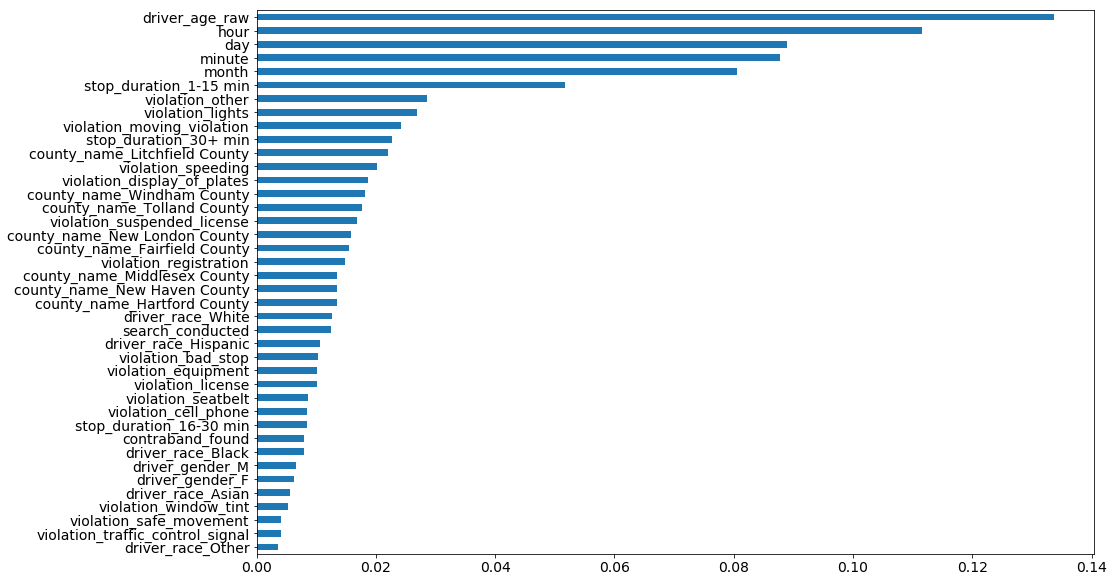

In [16]:
gbc_tuned_df = pd.DataFrame(data=clf['gbc_tuned'].clf.feature_importances_, index=X_train.columns.values)
gbc_tuned_plot = gbc_tuned_df.sort_values(by=0).plot.barh(figsize=(15, 10), fontsize=14)
gbc_tuned_plot.axes.legend().set_visible(False)

In [17]:
keys = clf.keys()
scores = [clf[key].score_val for key in keys]
results = pd.Series(scores, index=keys)
results

sgd          0.694371
gnb          0.643051
dtc          0.537262
rfc          0.685543
gbc          0.718311
gbc_tuned    0.717432
dtype: float64